In [1]:
import sys
sys.path.append("../Python")
from array import array
import time
import numpy as np
import feather
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import os
import ROOT as R
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
print(f"Tensorflow version: {tf.__version__}")

Welcome to JupyROOT 6.29/01
Tensorflow version: 2.9.0


# ML Tests
We load the *Pandas* version of a dataset from disk. Note that this is a bit of a shift in how a dataframe behaves!
By rounding the "true_e" parameter we undo the tiny variation introduced by writing and reading the data.

In [2]:
df = pd.read_feather("electrons_n1.feather")
df['true_e'] = df['true_e'].round(1)                       # Rounded version to one decimal.
df['one_over_e'] = 1/df['energy']
df['one_over_sqrt_e'] = 1/np.sqrt(df['energy'])

ran_loc = np.random.permutation(len(df))                   # To randomize the entries in the data set.
df.iloc[ran_loc].head()

dfc = df[["energy", "x", "y", "nhits", "seed_e", "one_over_e", "one_over_sqrt_e"]].copy()
dfy = df[['score_e']].copy()
linreg = LinearRegression()
#
# We need to split the data set into a "fit" set and a "validate" set.
# This needs to be done on the randomized locations in iloc.
split_frac = 0.5
split_point = int(len(ran_loc)*split_frac)
fit_loc = ran_loc[0:split_point]
val_loc = ran_loc[split_point:]
dfc_fit = dfc.iloc[fit_loc]
dfy_fit = dfy.iloc[fit_loc]
dfc_val = dfc.iloc[val_loc]
dfy_val = dfy.iloc[val_loc]
dfc_val

,energy,x,y,nhits,seed_e,one_over_e,one_over_sqrt_e
5673881,2.214223,-110.045448,-42.089382,8,1.613302,0.451626,0.672031
1509170,1.867721,-87.385361,-39.150188,4,1.438041,0.535412,0.731718
7374537,1.681747,-235.052032,-38.718678,4,1.121227,0.594620,0.771116
4347386,3.122679,-113.761353,72.658691,12,2.099947,0.320238,0.565896
952296,1.318351,-211.388718,-28.432343,3,1.214853,0.758523,0.870932
...,...,...,...,...,...,...,...
1172108,2.477399,-167.436203,-28.422344,6,2.077195,0.403649,0.635334
7397438,1.633501,-138.348068,-28.416655,4,1.377376,0.612182,0.782421
486140,1.672913,-66.782097,-49.729622,5,0.640273,0.597760,0.773149
1218740,1.882400,14.970742,42.954353,3,1.102692,0.531237,0.728860


## Plots of previous fits
We make the same plots as in MLTests.ipynb using the same fit constants, but now with data that is *not* cut with fiducial cuts.

In [3]:
lin_coeffs=np.array([1.0654241015592467, 0., 0., -0.041129075826791095,-0.05135978227167387,0.3478903440606219,-1.1392337125449232])
lin_const=1.175640246070988
Ypred_linear_old = np.dot(dfc_val,lin_coeffs) + lin_const

In [4]:
tmp_data = {key: df.iloc[val_loc][key].values for key in ['true_e', 'energy','energy_cor']}
tmp_data['energy_fit'] = Ypred_linear_old
rdf_linear_old_val = R.RDF.FromNumpy(tmp_data)
h1_true = rdf_linear_old_val.Histo1D(("h_true","True Energy;E [GeV]", 1000, 0., 4.),"true_e")
h1_clus = rdf_linear_old_val.Histo1D(("h_clus","Cluster Energy;E [GeV]", 1000, 0., 4.),"energy")
h1_clus_cor = rdf_linear_old_val.Histo1D(("h_clus_cor","Cluster Energy Cor;E [GeV]", 1000, 0., 4.),"energy_cor")
h1_fit = rdf_linear_old_val.Histo1D(("h_fit","Fit Energy;E [GeV]", 1000, 0., 4.),"energy_fit")
h1_df_clus = rdf_linear_old_val.Define("d","true_e - energy").Histo1D(("h_df_clus","Diff True - Cluster E;#Delta E [GeV]", 1000, -0.5,0.8),"d")
h1_df_clus_cor = rdf_linear_old_val.Define("d","true_e - energy_cor").Histo1D(("h_df_clus_cor","Diff True - Corrected Cluster E;#Delta E [GeV]", 1000, -0.2,0.8),"d")
h1_df_fit = rdf_linear_old_val.Define("d","true_e - energy_fit").Histo1D(("h_df_fit","Diff True - Fit E;#Delta E [GeV]", 1000, -0.5,0.8),"d")

Info in <TCanvas::Print>: pdf file Electron_score_e_LR1.pdf has been created


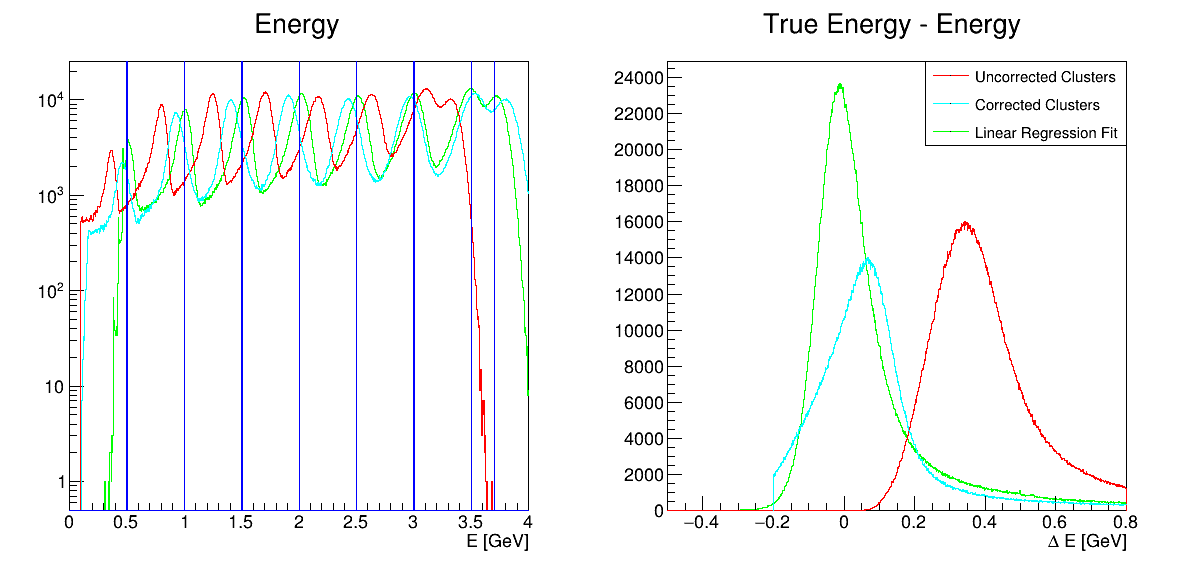

In [5]:
cc0 = R.TCanvas("cc0","cc0",1200,600)
cc0.Divide(2,1)
p1 = cc0.cd(1)
p1.SetLogy()
h1_clus.SetLineColor(R.kRed)
h1_clus_cor.SetLineColor(R.kCyan)
h1_fit.SetLineColor(R.kGreen)
h1_fit.SetStats(0)
h1_fit.SetTitle("Energy")
h1_fit.Draw()
h1_clus.Draw("same")
h1_clus_cor.Draw("same")
h1_true.SetLineColor(R.kBlue)
h1_true.Draw("same")
p2 = cc0.cd(2)
h1_df_clus.SetLineColor(R.kRed)
h1_df_clus_cor.SetLineColor(R.kCyan)
h1_df_fit.SetLineColor(R.kGreen)
h1_df_fit.SetStats(0)
h1_df_fit.SetTitle("True Energy - Energy")
h1_df_fit.Draw()
h1_df_clus.Draw("same")
h1_df_clus_cor.Draw("same")
leg0_p2 = R.TLegend(0.55,0.75,0.9,0.9)
leg0_p2.AddEntry(h1_df_clus.GetPtr(),"Uncorrected Clusters")
leg0_p2.AddEntry(h1_df_clus_cor.GetPtr(),"Corrected Clusters")
leg0_p2.AddEntry(h1_df_fit.GetPtr(),"Linear Regression Fit")
leg0_p2.Draw()
cc0.Draw()
cc0.SaveAs("Electron_score_e_LR1.pdf")

# Linear Regressions
We again run the linear regressions from SkLearn over the data, this time the data also has the edge clusters.

In [6]:
%time linreg.fit(dfc_fit,dfy_fit)
Ypred_fit = linreg.predict(dfc_fit)
Ypred_val = linreg.predict(dfc_val)
print(f"Mean square error fit         = {mean_squared_error(dfy_fit,Ypred_fit)}")
print(f"Mean square error validation  = {mean_squared_error(dfy_val,Ypred_val)}")
print("Coefficients:")
for i in range(len(linreg.coef_[0])):
    print(f"[{i:2d}] {linreg.feature_names_in_[i]:16s} * {linreg.coef_[0][i]:9.5f}")
print(f"         {' ':16s} {linreg.intercept_[0]}")

CPU times: user 384 ms, sys: 140 ms, total: 524 ms
Wall time: 489 ms
Mean square error fit         = 0.10505104348472384
Mean square error validation  = 0.10540122524713416
Coefficients:
[ 0] energy           *   1.12083
[ 1] x                *   0.00002
[ 2] y                *  -0.00005
[ 3] nhits            *  -0.10974
[ 4] seed_e           *   0.05392
[ 5] one_over_e       *   0.18174
[ 6] one_over_sqrt_e  *  -0.60179
                          1.144083530700154


In [7]:
# tmp_data = {key: df.iloc[fit_loc][key].values for key in ['true_e', 'energy','energy_cor']}
# tmp_data['energy_fit'] = Ypred_fit[:,0]
# rdf_fit = R.RDF.FromNumpy(tmp_data)
tmp_data = {key: df.iloc[val_loc][key].values for key in ['true_e', 'energy','energy_cor']}
tmp_data['energy_fit'] = Ypred_val[:,0]
rdf_val = R.RDF.FromNumpy(tmp_data)

In [8]:
# h1_true = rdf_fit.Histo1D(("h_true","True Energy;E [GeV]", 1000, 0., 4.),"true_e")
# h1_clus = rdf_fit.Histo1D(("h_clus","Cluster Energy;E [GeV]", 1000, 0., 4.),"energy")
# h1_clus_cor = rdf_fit.Histo1D(("h_clus_cor","Cluster Energy Cor;E [GeV]", 1000, 0., 4.),"energy_cor")
# h1_fit = rdf_fit.Histo1D(("h_fit","Fit Energy;E [GeV]", 1000, 0., 4.),"energy_fit")
# h1_df_clus = rdf_fit.Define("d","true_e - energy").Histo1D(("h_df_clus","Diff True - Cluster E;#Delta E [GeV]", 1000, -0.5,0.8),"d")
# h1_df_clus_cor = rdf_fit.Define("d","true_e - energy_cor").Histo1D(("h_df_clus_cor","Diff True - Corrected Cluster E;#Delta E [GeV]", 1000, -0.2,0.8),"d")
# h1_df_fit = rdf_fit.Define("d","true_e - energy_fit").Histo1D(("h_df_fit","Diff True - Fit E;#Delta E [GeV]", 1000, -0.5,0.8),"d")
h2_true = rdf_val.Histo1D(("h_true","True Energy;E [GeV]", 1000, 0., 4.),"true_e")
h2_clus = rdf_val.Histo1D(("h_clus","Cluster Energy;E [GeV]", 1000, 0., 4.),"energy")
h2_clus_cor = rdf_val.Histo1D(("h_clus_cor","Cluster Energy Cor;E [GeV]", 1000, 0., 4.),"energy_cor")
h2_fit = rdf_val.Histo1D(("h_fit","Fit Energy;E [GeV]", 1000, 0., 4.),"energy_fit")
h2_df_clus = rdf_val.Define("d","true_e - energy").Histo1D(("h_df_clus","Diff True - Cluster E;#Delta E [GeV]", 1000, -0.5,0.8),"d")
h2_df_clus_cor = rdf_val.Define("d","true_e - energy_cor").Histo1D(("h_df_clus_cor","Diff True - Corrected Cluster E;#Delta E [GeV]", 1000, -0.2,0.8),"d")
h2_df_fit = rdf_val.Define("d","true_e - energy_fit").Histo1D(("h_df_fit","Diff True - Fit E;#Delta E [GeV]", 1000, -0.5,0.8),"d")

Info in <TCanvas::Print>: pdf file Electron_score_e_LR1_no_fidcut.pdf has been created


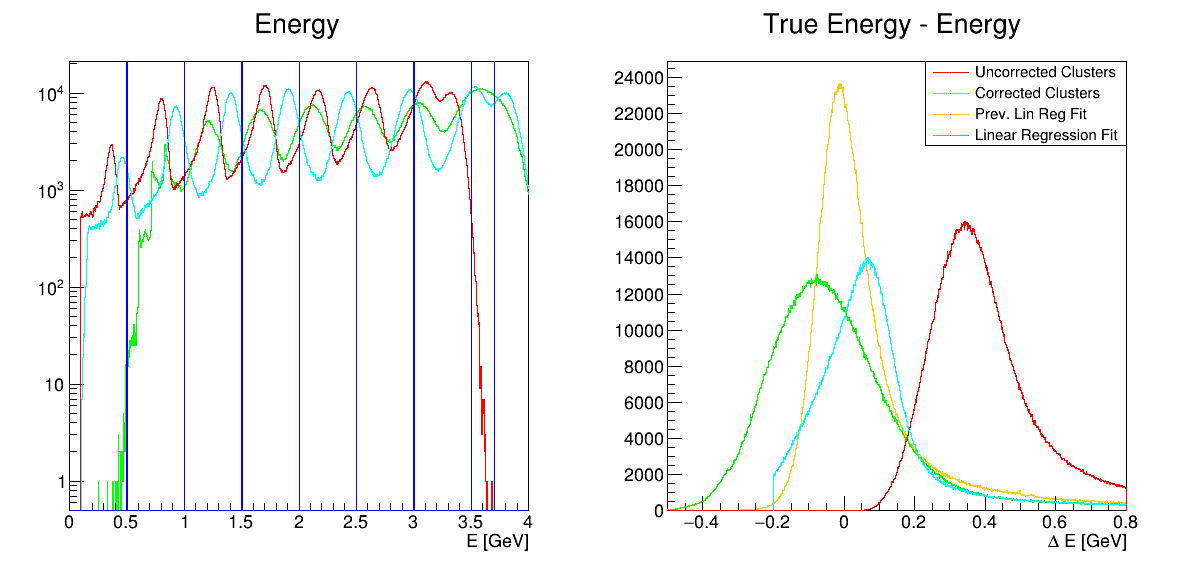

In [9]:
cc = R.TCanvas("cc","CC",1200,600)
cc.Divide(2,1)
p1 = cc.cd(1)
p1.SetLogy()
h2_clus.SetLineColor(R.kRed)
h2_clus_cor.SetLineColor(R.kCyan)
h2_fit.SetLineColor(R.kGreen)
h2_fit.SetStats(0)
h2_fit.SetTitle("Energy")
h2_fit.Draw()
h2_clus.Draw("same")
h2_clus_cor.Draw("same")
h2_true.SetLineColor(R.kBlue)
h2_true.Draw("same")
p2 = cc.cd(2)
h2_df_clus.SetLineColor(R.kRed)
h2_df_clus_cor.SetLineColor(R.kCyan)
h2_df_fit.SetLineColor(R.kGreen)
h2_df_fit.SetStats(0)
h2_df_fit.SetTitle("True Energy - Energy")
h2_df_clus.SetStats(0)
h2_df_clus.SetTitle("True Energy - Energy")
h1_df_fit.SetStats(0)
h1_df_fit.SetTitle("True Energy - Energy")
h1_df_fit.SetLineColor(R.kOrange)
h1_df_fit.Draw()
h2_df_clus.Draw("same")
h2_df_fit.Draw("same")
h2_df_clus.Draw("same")
h2_df_clus_cor.Draw("same")
leg0_p2 = R.TLegend(0.55,0.75,0.9,0.9)
leg0_p2.AddEntry(h2_df_clus.GetPtr(),"Uncorrected Clusters")
leg0_p2.AddEntry(h2_df_clus_cor.GetPtr(),"Corrected Clusters")
leg0_p2.AddEntry(h1_df_fit.GetPtr(),"Prev. Lin Reg Fit")
leg0_p2.AddEntry(h2_df_fit.GetPtr(),"Linear Regression Fit")
leg0_p2.Draw()
cc.Draw()
cc.SaveAs("Electron_score_e_LR1_no_fidcut.pdf")

In [10]:
# Number of entries in each histogram.
print(h2_df_clus.GetEntries(), h2_df_clus_cor.GetEntries(), h1_df_fit.GetEntries(), h2_df_fit.GetEntries())
print(f"Ecal cluster,     N = {h2_df_clus_cor.GetEntries()} mu = {h2_df_clus_cor.GetMean():8.5f} rms={h2_df_clus_cor.GetRMS():8.5f}")
print(f"Old Lin. Reg fit, N = {h1_df_fit.GetEntries()} mu = {h1_df_fit.GetMean():8.5f} rms={h1_df_fit.GetRMS():8.5f}")
print(f"New Lin. Reg fit, N = {h2_df_fit.GetEntries()} mu = {h2_df_fit.GetMean():8.5f} rms={h2_df_fit.GetRMS():8.5f}")

4019803.0 4019803.0 4019803.0 4019803.0
Ecal cluster,     N = 4019803.0 mu =  0.07582 rms= 0.16142
Old Lin. Reg fit, N = 4019803.0 mu =  0.06016 rms= 0.16381
New Lin. Reg fit, N = 4019803.0 mu = -0.02342 rms= 0.19301


## Going to higher order polynomial fit.
We can go to cubic polynomial combinations of the variables, and trying to be careful to weed out obvious trouble parameters. This does not seem to buy us any improvement in the fit. It appears that higher order terms do not help.

In [11]:
pol_feature = PolynomialFeatures(degree=3, include_bias=False)
tmp = pol_feature.fit_transform(dfc_fit)
dfc_fit_pol = pd.DataFrame(tmp, columns=pol_feature.get_feature_names_out())
dfc_fit_pol.drop(columns=['energy one_over_e','energy^2 one_over_e','one_over_sqrt_e^2','energy^2 one_over_e',
                          'energy nhits one_over_e','energy seed_e one_over_e', 'energy seed_e one_over_sqrt_e',
                          'energy one_over_e^2', 'energy one_over_e one_over_sqrt_e','energy one_over_sqrt_e^2',
                          'nhits one_over_sqrt_e^2', 'seed_e one_over_sqrt_e^2', 'one_over_e one_over_sqrt_e^2',
                          'one_over_sqrt_e^3', 'energy one_over_sqrt_e','energy^2 one_over_sqrt_e',
                          'energy nhits one_over_sqrt_e','one_over_e one_over_sqrt_e'], inplace=True)
tmp = pol_feature.fit_transform(dfc_val)
dfc_val_pol = pd.DataFrame(tmp, columns=pol_feature.get_feature_names_out())
dfc_val_pol.drop(columns=['energy one_over_e','energy^2 one_over_e','one_over_sqrt_e^2','energy^2 one_over_e',
                          'energy nhits one_over_e','energy seed_e one_over_e', 'energy seed_e one_over_sqrt_e',
                          'energy one_over_e^2', 'energy one_over_e one_over_sqrt_e','energy one_over_sqrt_e^2',
                          'nhits one_over_sqrt_e^2', 'seed_e one_over_sqrt_e^2', 'one_over_e one_over_sqrt_e^2',
                          'one_over_sqrt_e^3', 'energy one_over_sqrt_e', 'energy^2 one_over_sqrt_e',
                          'energy nhits one_over_sqrt_e','one_over_e one_over_sqrt_e'], inplace=True)
linreg_pol = LinearRegression()
%time linreg_pol.fit(dfc_fit_pol,dfy_fit)
Ypred_fit_pol = linreg_pol.predict(dfc_fit_pol)
Ypred_val_pol = linreg_pol.predict(dfc_val_pol)
print(f"Mean square error for fit        = {mean_squared_error(dfy_fit,Ypred_fit)}")
print(f"Mean square error for validation = {mean_squared_error(dfy_val,Ypred_val)}")
for i in range(len(linreg_pol.coef_[0])):
    print(f"[{i:2d}] {linreg_pol.feature_names_in_[i]:16s} * {linreg_pol.coef_[0][i]:9.5f}")
print(f"         {' ':16s} {linreg_pol.intercept_[0]}")

CPU times: user 39.9 s, sys: 2.11 s, total: 42 s
Wall time: 12.3 s
Mean square error for fit        = 0.10505104348472384
Mean square error for validation = 0.10540122524713416
[ 0] energy           *  -7.02690
[ 1] x                *   0.01078
[ 2] y                *  -0.19423
[ 3] nhits            *   0.05101
[ 4] seed_e           *  -2.74297
[ 5] one_over_e       *  18.91546
[ 6] one_over_sqrt_e  * -34.64746
[ 7] energy^2         *   2.44054
[ 8] energy x         *  -0.00664
[ 9] energy y         *  -0.06797
[10] energy nhits     *  -0.16113
[11] energy seed_e    *  -1.35641
[12] x^2              *  -0.00001
[13] x y              *  -0.00000
[14] x nhits          *   0.00124
[15] x seed_e         *  -0.00440
[16] x one_over_e     *   0.02830
[17] x one_over_sqrt_e *  -0.06047
[18] y^2              *  -0.00006
[19] y nhits          *   0.00114
[20] y seed_e         *  -0.00117
[21] y one_over_e     *  -0.07474
[22] y one_over_sqrt_e *   0.32865
[23] nhits^2          *  -0.04839
[24] 

In [12]:
tmp_data = {key: df.iloc[val_loc][key].values for key in ['true_e', 'energy','energy_cor']}
tmp_data['energy_pol_fit'] = Ypred_val_pol[:,0]
rdf_pol = R.RDF.FromNumpy(tmp_data)

In [13]:
h3_fit = rdf_pol.Histo1D(("h3_fit", "Fit Energy;E [GeV]", 1000, 0., 4.), "energy_pol_fit")
h3_df_fit = rdf_pol.Define("d", "true_e - energy_pol_fit").Histo1D(
    ("h3_df_fit", "Diff True - Fit E;#Delta E [GeV]", 1000, -0.5, 0.8), "d")


Warning in <TCanvas::Constructor>: Deleting canvas with same name: cc
Info in <TCanvas::Print>: pdf file Electron_score_e_LR3_nofidcut.pdf has been created


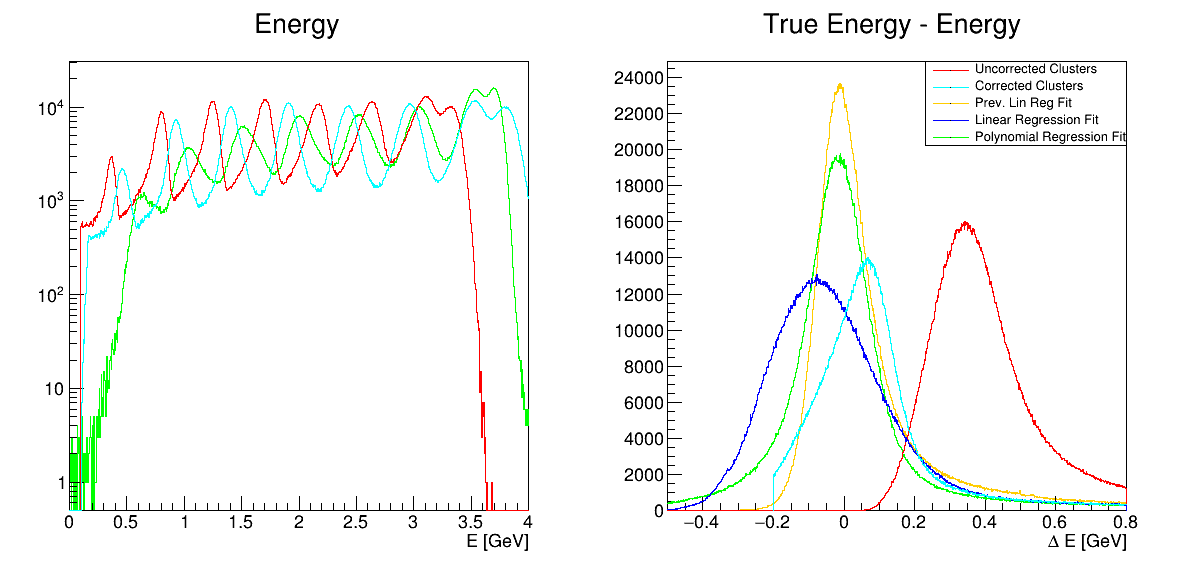

In [14]:
cc = R.TCanvas("cc","CC",1200,600)
cc.Divide(2,1)
p1 = cc.cd(1)
p1.SetLogy()
#h_true.SetLineColor(R.kBlue)
#h_true.Draw()
h2_clus.SetLineColor(R.kRed)
h2_clus_cor.SetLineColor(R.kCyan)
h3_fit.SetLineColor(R.kGreen)
h3_fit.SetStats(0)
h3_fit.SetTitle("Energy")
h3_fit.Draw()
h2_clus.Draw("same")
h2_clus_cor.Draw("same")
p2 = cc.cd(2)
h2_df_clus.SetLineColor(R.kRed)
h2_df_clus_cor.SetLineColor(R.kCyan)
h3_df_fit.SetLineColor(R.kGreen)
h3_df_fit.SetStats(0)
h3_df_fit.SetTitle("True Energy - Energy")
h1_df_fit.Draw()
h3_df_fit.Draw("same")
h2_df_clus.Draw("same")
h2_df_fit.SetLineColor(R.kBlue)
h2_df_fit.Draw("same")
h2_df_clus_cor.Draw("same")
leg0_p2 = R.TLegend(0.55,0.75,0.9,0.9)
leg0_p2.AddEntry(h2_df_clus.GetPtr(),"Uncorrected Clusters")
leg0_p2.AddEntry(h2_df_clus_cor.GetPtr(),"Corrected Clusters")
leg0_p2.AddEntry(h1_df_fit.GetPtr(),"Prev. Lin Reg Fit")
leg0_p2.AddEntry(h2_df_fit.GetPtr(),"Linear Regression Fit")
leg0_p2.AddEntry(h3_df_fit.GetPtr(),"Polynomial Regression Fit")
leg0_p2.Draw()
cc.Draw()
cc.SaveAs("Electron_score_e_LR3_nofidcut.pdf")

# Semi-Deep Neural Network, 2 Layer.
Working with more parameters and some non-linear part, we end up with a lot more parameters, much less of an idea what these parameters do,
and the results are no better, with a Mean Squared Error of 0.022. Just the training takes a lot longer.

Training for this model is in a separate Python file, MLTrainer2.py
Here we copy the weights from that training.

In [15]:
model2 = keras.Sequential([
    keras.Input(shape=(5,)),
    layers.Dense(20, activation="linear",
                 kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.1, stddev=0.01),
                 bias_initializer=tf.keras.initializers.Zeros()),
    layers.Dense(1, activation="relu",
                 kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.1, stddev=0.01),
                 bias_initializer=tf.keras.initializers.Zeros())


])
model2.compile(
    # optimizer=tf.optimizers.SGD(learning_rate=0.000001),
    optimizer=tf.optimizers.Adam(learning_rate=0.0001),
    loss="mse"
    # tf.keras.losses.MeanSquaredError() # alternate: 'mean_absolute_error'='mae', 'mean_squared_error' = 'mse'
)


Metal device set to: Apple M1 Max

systemMemory: 64.00 GB
maxCacheSize: 24.00 GB



2023-04-09 22:45:11.882255: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-04-09 22:45:11.882370: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [16]:
import json
with open("MLTrainer2_Data.json", "r") as read_file:
    decodedArray = json.load(read_file)
weight_array = decodedArray['weights_store']
weights = []
for w in weight_array[-1]:
    weights.append(np.array(w))
model2.set_weights(weights)

FileNotFoundError: [Errno 2] No such file or directory: 'MLTrainer2_Data.json'

In [33]:
# Note that even just running the prediction now takes quite a bit of time!
%time Ypred_fit_NN2 = model2.predict(dfc_fit)

CPU times: user 1e+03 ns, sys: 1 µs, total: 2 µs
Wall time: 4.77 µs
76146/76146 [==============================] - 116s 2ms/step


2023-04-07 13:30:41.803010: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-04-07 13:30:41.837001: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [36]:
%time Ypred_val_NN2 = model2.predict(dfc_val)

76146/76146 [==============================] - 102s 1ms/step
CPU times: user 1min 15s, sys: 28.1 s, total: 1min 43s
Wall time: 1min 51s


In [37]:
print(f"MSE Fit: {mean_squared_error(Ypred_fit_NN2, dfy_fit)}")
print(f"MSE Val: {mean_squared_error(Ypred_val_NN2, dfy_val)}")

MSE Fit: 0.022492667938490286
MSE Val: 0.022467700728637467


In [38]:
tmp_data = {key: df.iloc[val_loc][key].values for key in ['true_e', 'score_e', 'energy','energy_cor']}
tmp_data['energy_NN2'] = Ypred_val_NN2[:,0]
rdf_NN2 = R.RDF.FromNumpy(tmp_data)

Info in <TCanvas::Print>: pdf file Electron_score_e_NN2.pdf has been created


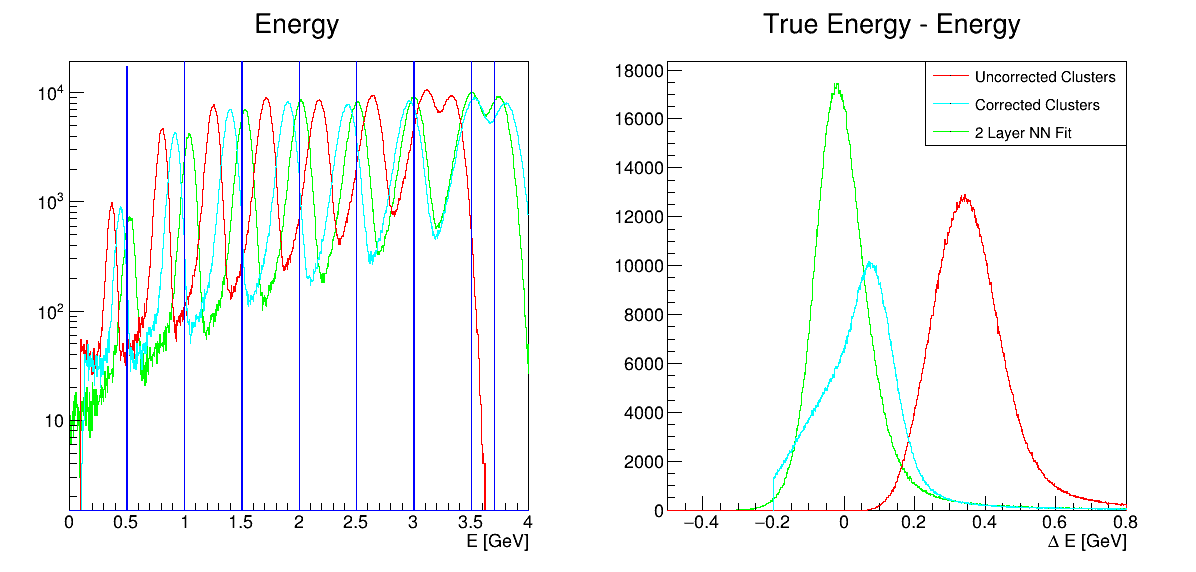

In [40]:
h5_true = rdf_NN2.Histo1D(("h_true", "True Energy;E [GeV]", 1000, 0., 4.), "true_e")
h5_clus = rdf_NN2.Histo1D(("h_clus", "Cluster Energy;E [GeV]", 1000, 0., 4.), "energy")
h5_clus_cor = rdf_NN2.Histo1D(("h_clus_cor", "Cluster Energy Cor;E [GeV]", 1000, 0., 4.), "energy_cor")
h5_fit = rdf_NN2.Histo1D(("h_fit", "Fit Energy;E [GeV]", 1000, 0., 4.), "energy_NN2")
h5_df_clus = rdf_NN2.Define("d", "true_e - energy").Histo1D(
    ("h_df_clus", "Diff True - Cluster E;#Delta E [GeV]", 1000, -0.5, 0.8), "d")
h5_df_clus_cor = rdf_NN2.Define("d", "true_e - energy_cor").Histo1D(
    ("h_df_clus_cor", "Diff True - Corrected Cluster E;#Delta E [GeV]", 1000, -0.2, 0.8), "d")
h5_df_fit = rdf_NN2.Define("d", "true_e - energy_NN2").Histo1D(
    ("h_df_fit", "Diff True - Fit E;#Delta E [GeV]", 1000, -0.5, 0.8), "d")
cc5 = R.TCanvas("cc5", "cc5", 1200, 600)
cc5.Divide(2, 1)
p1 = cc5.cd(1)
p1.SetLogy()
h5_clus.SetLineColor(R.kRed)
h5_clus_cor.SetLineColor(R.kCyan)
h5_fit.SetLineColor(R.kGreen)
h5_fit.SetStats(0)
h5_fit.SetTitle("Energy")
h5_fit.Draw()
h5_clus.Draw("same")
h5_clus_cor.Draw("same")
h5_true.SetLineColor(R.kBlue)
h5_true.Draw("same")
p2 = cc5.cd(2)
h5_df_clus.SetLineColor(R.kRed)
h5_df_clus_cor.SetLineColor(R.kCyan)
h5_df_fit.SetLineColor(R.kGreen)
h5_df_fit.SetStats(0)
h5_df_fit.SetTitle("True Energy - Energy")
h5_df_fit.Draw()
h5_df_clus.Draw("same")
h5_df_clus_cor.Draw("same")
leg5_p2 = R.TLegend(0.55, 0.75, 0.9, 0.9)
leg5_p2.AddEntry(h5_df_clus.GetPtr(), "Uncorrected Clusters")
leg5_p2.AddEntry(h5_df_clus_cor.GetPtr(), "Corrected Clusters")
leg5_p2.AddEntry(h5_df_fit.GetPtr(), "2 Layer NN Fit")
leg5_p2.Draw()
cc5.Draw()
cc5.SaveAs("Electron_score_e_NN2.pdf")

In [44]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 20)                120       
                                                                 
 dense_2 (Dense)             (None, 1)                 21        
                                                                 
Total params: 141
Trainable params: 141
Non-trainable params: 0
_________________________________________________________________


# Deep Learning Model
So finally, we try a deep learning model, with 10801 parameters, so you have absolutely no clue what is happening inside.
To limit the training time, we train the model on 5% of the data, and validate with 10% of the data.

This model appears to be just marginally better, with a loss (MSE) of 0.0174 instead of 0.022. This was reached after 40 batch steps, or 8 epochs.
Training a full 20 epocs only sees the loss bounce between 0.0206 and 0.0173.

The model requires 8 GB to train, and about 7 seconds per batch (31s to train of 50% of the data).

```./MLTrainer3.py --rate 0.01  --rate 0.001 -t 5 -s 5 -n 20  --root -d  electrons_fiducial_cut_n1.feather
Tensorflow version: 2.11.0
Starting values:
Mean square error for the fit    = 0
Mean square error for validation = 0
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #
=================================================================
 dense (Dense)               (None, 100)               600

 dense_1 (Dense)             (None, 100)               10100

 dense_2 (Dense)             (None, 1)                 101

=================================================================
Total params: 10,801
Trainable params: 10,801
Non-trainable params: 0
...
...
Final values:
Loss                             = 0.018097009509801865
Mean square error for the fit    = 0.017716576601145624
Mean square error for validation = 0.017451943974658508
```

This model had no "regularization" of the parameters, and while the validation and fit loss are very close, the graph of the result makes it seem
that there is some level of over-fitting, or at least strange behavior, happening here.

In [17]:
rfile = R.TFile("MLTrainer3_data_val_no_regulation.root")
t = rfile.Get("EcalTraining")
rdf_NN3 = R.RDataFrame(t)
rdf_NN3.GetColumnNames()

vector<string>{ "energy", "energy_NN", "energy_cor", "nhits", "one_over_e", "one_over_sqrt_e", "score_e", "seed_e", "true_e" }

Info in <TCanvas::Print>: pdf file Electron_score_e_NN3_no_regulation.pdf has been created


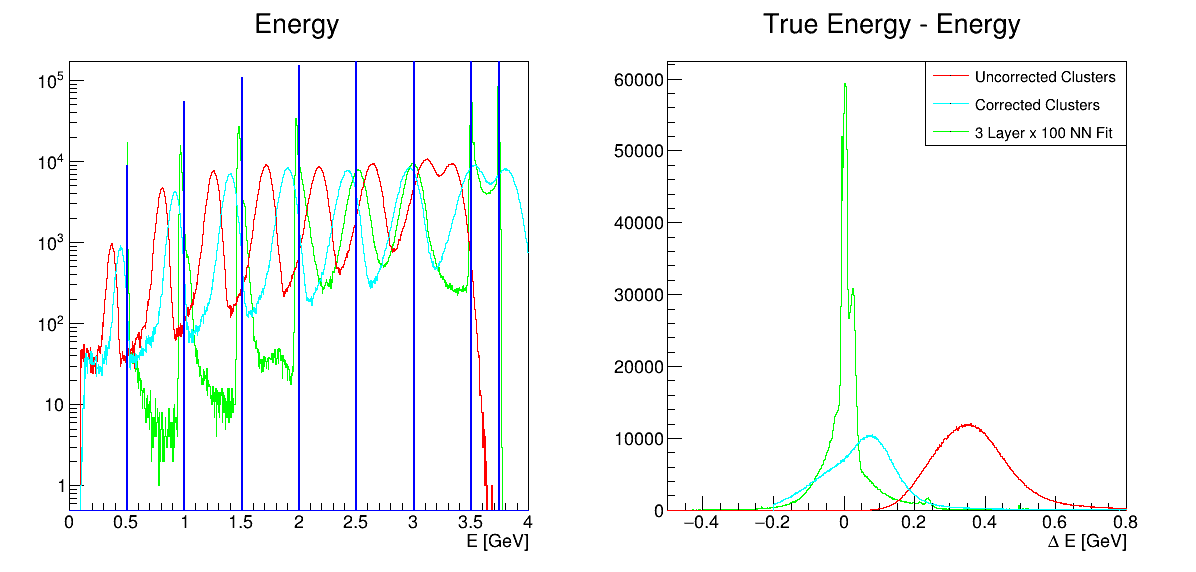

In [18]:
h6_true = rdf_NN3.Histo1D(("h_true", "True Energy;E [GeV]", 1000, 0., 4.), "true_e")
h6_clus = rdf_NN3.Histo1D(("h_clus", "Cluster Energy;E [GeV]", 1000, 0., 4.), "energy")
h6_clus_cor = rdf_NN3.Histo1D(("h_clus_cor", "Cluster Energy Cor;E [GeV]", 1000, 0., 4.), "energy_cor")
h6_fit = rdf_NN3.Histo1D(("h_fit", "Fit Energy;E [GeV]", 1000, 0., 4.), "energy_NN")
h6_df_clus = rdf_NN3.Define("d", "true_e - energy").Histo1D(
    ("h_df_clus", "Diff True - Cluster E;#Delta E [GeV]", 1000, -0.5, 0.8), "d")
h6_df_clus_cor = rdf_NN3.Define("d", "true_e - energy_cor").Histo1D(
    ("h_df_clus_cor", "Diff True - Corrected Cluster E;#Delta E [GeV]", 1000, -0.2, 0.8), "d")
h6_df_fit = rdf_NN3.Define("d", "true_e - energy_NN").Histo1D(
    ("h_df_fit", "Diff True - Fit E;#Delta E [GeV]", 1000, -0.5, 0.8), "d")
cc6 = R.TCanvas("cc6", "cc6", 1200, 600)
cc6.Divide(2, 1)
p1 = cc6.cd(1)
p1.SetLogy()
h6_clus.SetLineColor(R.kRed)
h6_clus_cor.SetLineColor(R.kCyan)
h6_fit.SetLineColor(R.kGreen)
h6_fit.SetStats(0)
h6_fit.SetTitle("Energy")
h6_fit.Draw()
h6_clus.Draw("same")
h6_clus_cor.Draw("same")
h6_true.SetLineColor(R.kBlue)
h6_true.Draw("same")
p2 = cc6.cd(2)
h6_df_clus.SetLineColor(R.kRed)
h6_df_clus_cor.SetLineColor(R.kCyan)
h6_df_fit.SetLineColor(R.kGreen)
h6_df_fit.SetStats(0)
h6_df_fit.SetTitle("True Energy - Energy")
h6_df_fit.Draw()
h6_df_clus.Draw("same")
h6_df_clus_cor.Draw("same")
leg6_p2 = R.TLegend(0.55, 0.75, 0.9, 0.9)
leg6_p2.AddEntry(h6_df_clus.GetPtr(), "Uncorrected Clusters")
leg6_p2.AddEntry(h6_df_clus_cor.GetPtr(), "Corrected Clusters")
leg6_p2.AddEntry(h6_df_fit.GetPtr(), "3 Layer x 100 NN Fit")
leg6_p2.Draw()
cc6.Draw()
cc6.SaveAs("Electron_score_e_NN3_no_regulation.pdf")

## Add Regulation to the Model
We add an L2 regulation to all the layers in the model. The result is now again close to the previous results:
```
Loss                             = 0.05406823009252548
Mean square error for the fit    = 0.02278002218551103
Mean square error for validation = 0.022799865437876887
```
And the histogram looks the same again too.

Warning in <TCanvas::Constructor>: Deleting canvas with same name: cc6
Info in <TCanvas::Print>: pdf file Electron_score_e_NN3_L2_pt01.pdf has been created


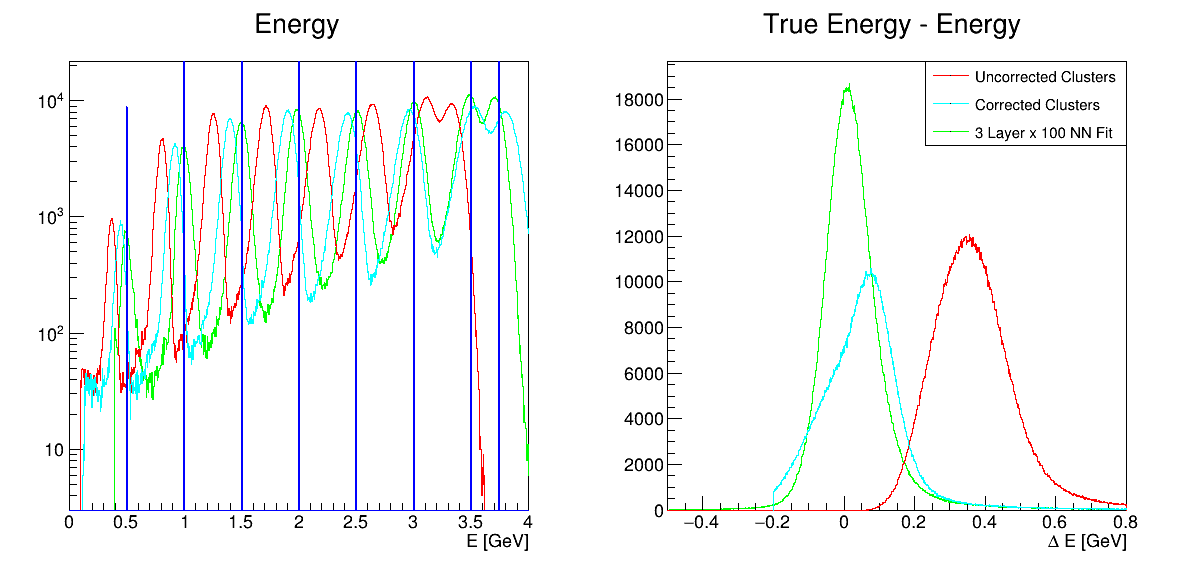

In [19]:
rfile = R.TFile("MLTrainer3_data_val.root")
t = rfile.Get("EcalTraining")
rdf_NN3 = R.RDataFrame(t)
rdf_NN3.GetColumnNames()
h6_true = rdf_NN3.Histo1D(("h_true", "True Energy;E [GeV]", 1000, 0., 4.), "true_e")
h6_clus = rdf_NN3.Histo1D(("h_clus", "Cluster Energy;E [GeV]", 1000, 0., 4.), "energy")
h6_clus_cor = rdf_NN3.Histo1D(("h_clus_cor", "Cluster Energy Cor;E [GeV]", 1000, 0., 4.), "energy_cor")
h6_fit = rdf_NN3.Histo1D(("h_fit", "Fit Energy;E [GeV]", 1000, 0., 4.), "energy_NN")
h6_df_clus = rdf_NN3.Define("d", "true_e - energy").Histo1D(
    ("h_df_clus", "Diff True - Cluster E;#Delta E [GeV]", 1000, -0.5, 0.8), "d")
h6_df_clus_cor = rdf_NN3.Define("d", "true_e - energy_cor").Histo1D(
    ("h_df_clus_cor", "Diff True - Corrected Cluster E;#Delta E [GeV]", 1000, -0.2, 0.8), "d")
h6_df_fit = rdf_NN3.Define("d", "true_e - energy_NN").Histo1D(
    ("h_df_fit", "Diff True - Fit E;#Delta E [GeV]", 1000, -0.5, 0.8), "d")
cc6 = R.TCanvas("cc6", "cc6", 1200, 600)
cc6.Divide(2, 1)
p1 = cc6.cd(1)
p1.SetLogy()
h6_clus.SetLineColor(R.kRed)
h6_clus_cor.SetLineColor(R.kCyan)
h6_fit.SetLineColor(R.kGreen)
h6_fit.SetStats(0)
h6_fit.SetTitle("Energy")
h6_fit.Draw()
h6_clus.Draw("same")
h6_clus_cor.Draw("same")
h6_true.SetLineColor(R.kBlue)
h6_true.Draw("same")
p2 = cc6.cd(2)
h6_df_clus.SetLineColor(R.kRed)
h6_df_clus_cor.SetLineColor(R.kCyan)
h6_df_fit.SetLineColor(R.kGreen)
h6_df_fit.SetStats(0)
h6_df_fit.SetTitle("True Energy - Energy")
h6_df_fit.Draw()
h6_df_clus.Draw("same")
h6_df_clus_cor.Draw("same")
leg6_p2 = R.TLegend(0.55, 0.75, 0.9, 0.9)
leg6_p2.AddEntry(h6_df_clus.GetPtr(), "Uncorrected Clusters")
leg6_p2.AddEntry(h6_df_clus_cor.GetPtr(), "Corrected Clusters")
leg6_p2.AddEntry(h6_df_fit.GetPtr(), "3 Layer x 100 NN Fit")
leg6_p2.Draw()
cc6.Draw()
cc6.SaveAs("Electron_score_e_NN3_L2_pt01.pdf")

## Again
Reduce the L2 penalty from 0.01 to 0.001 and refit, and keep going down. This below is at 1e-16 for the $\alpha$ parameter, very small.


Warning in <TCanvas::Constructor>: Deleting canvas with same name: cc6
Info in <TCanvas::Print>: pdf file Electron_score_e_NN3_L2_1em16.pdf has been created


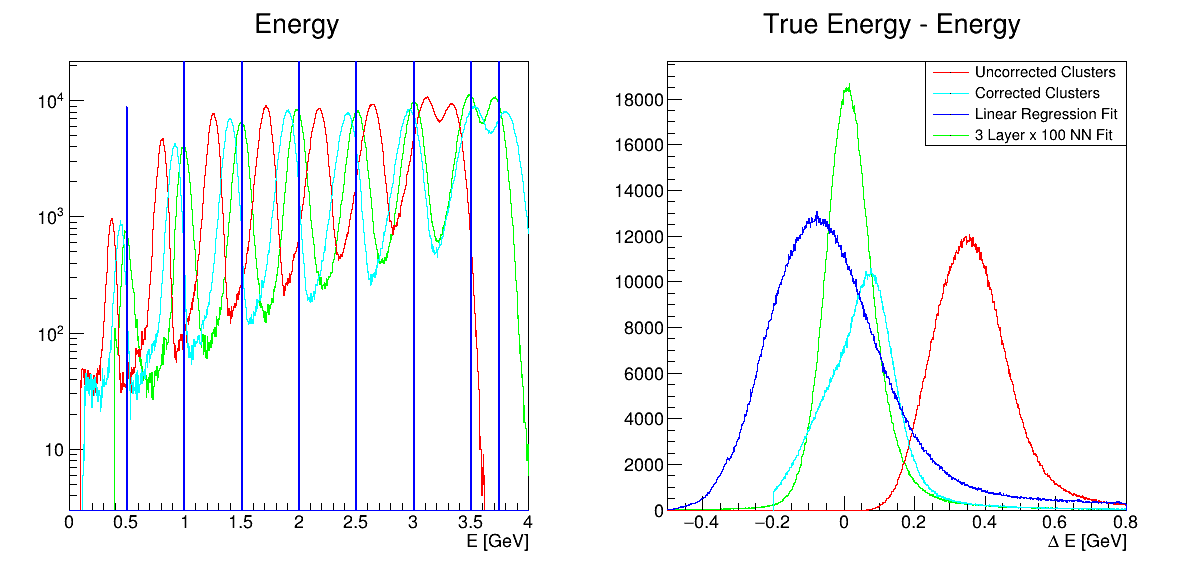

In [20]:
rfile = R.TFile("MLTrainer3_data_val.root")
t = rfile.Get("EcalTraining")
rdf_NN3 = R.RDataFrame(t)
rdf_NN3.GetColumnNames()
h6_true = rdf_NN3.Histo1D(("h_true", "True Energy;E [GeV]", 1000, 0., 4.), "true_e")
h6_clus = rdf_NN3.Histo1D(("h_clus", "Cluster Energy;E [GeV]", 1000, 0., 4.), "energy")
h6_clus_cor = rdf_NN3.Histo1D(("h_clus_cor", "Cluster Energy Cor;E [GeV]", 1000, 0., 4.), "energy_cor")
h6_fit = rdf_NN3.Histo1D(("h_fit", "Fit Energy;E [GeV]", 1000, 0., 4.), "energy_NN")
h6_df_clus = rdf_NN3.Define("d", "true_e - energy").Histo1D(
    ("h_df_clus", "Diff True - Cluster E;#Delta E [GeV]", 1000, -0.5, 0.8), "d")
h6_df_clus_cor = rdf_NN3.Define("d", "true_e - energy_cor").Histo1D(
    ("h_df_clus_cor", "Diff True - Corrected Cluster E;#Delta E [GeV]", 1000, -0.2, 0.8), "d")
h6_df_fit = rdf_NN3.Define("d", "true_e - energy_NN").Histo1D(
    ("h_df_fit", "Diff True - Fit E;#Delta E [GeV]", 1000, -0.5, 0.8), "d")
cc6 = R.TCanvas("cc6", "cc6", 1200, 600)
cc6.Divide(2, 1)
p1 = cc6.cd(1)
p1.SetLogy()
h6_clus.SetLineColor(R.kRed)
h6_clus_cor.SetLineColor(R.kCyan)
h6_fit.SetLineColor(R.kGreen)
h6_fit.SetStats(0)
h6_fit.SetTitle("Energy")
h6_fit.Draw()
h6_clus.Draw("same")
h6_clus_cor.Draw("same")
h6_true.SetLineColor(R.kBlue)
h6_true.Draw("same")
p2 = cc6.cd(2)
h6_df_clus.SetLineColor(R.kRed)
h6_df_clus_cor.SetLineColor(R.kCyan)
h6_df_fit.SetLineColor(R.kGreen)
h6_df_fit.SetStats(0)
h6_df_fit.SetTitle("True Energy - Energy")
h6_df_fit.Draw()
h6_df_clus.Draw("same")
h6_df_clus_cor.Draw("same")
h2_df_fit.SetLineColor(R.kBlue)
h2_df_fit.Draw("same")
leg6_p2 = R.TLegend(0.55, 0.75, 0.9, 0.9)
leg6_p2.AddEntry(h6_df_clus.GetPtr(), "Uncorrected Clusters")
leg6_p2.AddEntry(h6_df_clus_cor.GetPtr(), "Corrected Clusters")
leg6_p2.AddEntry(h2_df_fit.GetPtr(),"Linear Regression Fit")
leg6_p2.AddEntry(h6_df_fit.GetPtr(), "3 Layer x 100 NN Fit")
leg6_p2.Draw()
cc6.Draw()
cc6.SaveAs("Electron_score_e_NN3_L2_1em16.pdf")

In [21]:
print(f"Lin. Reg fit, mu = {h2_df_fit.GetMean():8.5f} rms={h2_df_fit.GetRMS():8.5f}")
print(f"Deep Learning mu = {h6_df_fit.GetMean():8.5f} rms={h6_df_fit.GetRMS():8.5f}")

Lin. Reg fit, mu = -0.02342 rms= 0.19301
Deep Learning mu =  0.02843 rms= 0.10158


Warning in <TCanvas::Constructor>: Deleting canvas with same name: cc6
Info in <TCanvas::Print>: pdf file Electron_score_e_NN3_L2_1em30_no_fidcut.pdf has been created


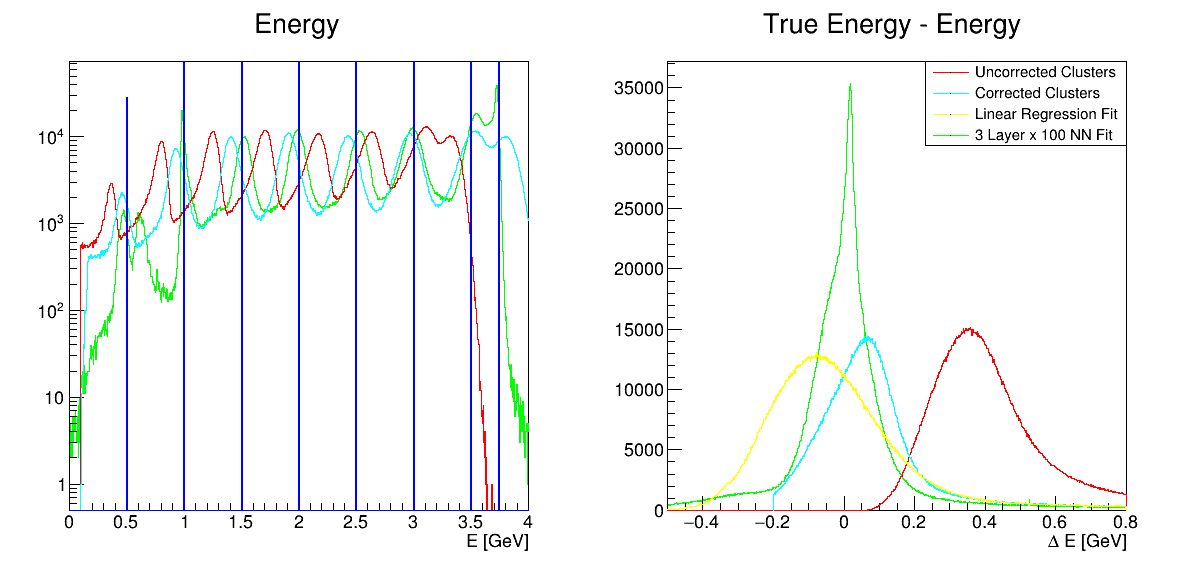

In [24]:
rfile = R.TFile("electrons_n1_M3_fit.root")
t = rfile.Get("EcalTraining")
rdf_NN3 = R.RDataFrame(t)
rdf_NN3.GetColumnNames()
h6_true = rdf_NN3.Histo1D(("h_true", "True Energy;E [GeV]", 1000, 0., 4.), "true_e")
h6_clus = rdf_NN3.Histo1D(("h_clus", "Cluster Energy;E [GeV]", 1000, 0., 4.), "energy")
h6_clus_cor = rdf_NN3.Histo1D(("h_clus_cor", "Cluster Energy Cor;E [GeV]", 1000, 0., 4.), "energy_cor")
h6_fit = rdf_NN3.Histo1D(("h_fit", "Fit Energy;E [GeV]", 1000, 0., 4.), "energy_NN")
h6_df_clus = rdf_NN3.Define("d", "true_e - energy").Histo1D(
    ("h_df_clus", "Diff True - Cluster E;#Delta E [GeV]", 1000, -0.5, 0.8), "d")
h6_df_clus_cor = rdf_NN3.Define("d", "true_e - energy_cor").Histo1D(
    ("h_df_clus_cor", "Diff True - Corrected Cluster E;#Delta E [GeV]", 1000, -0.2, 0.8), "d")
h6_df_fit = rdf_NN3.Define("d", "true_e - energy_NN").Histo1D(
    ("h_df_fit", "Diff True - Fit E;#Delta E [GeV]", 1000, -0.5, 0.8), "d")
cc6 = R.TCanvas("cc6", "cc6", 1200, 600)
cc6.Divide(2, 1)
p1 = cc6.cd(1)
p1.SetLogy()
h6_clus.SetLineColor(R.kRed)
h6_clus_cor.SetLineColor(R.kCyan)
h6_fit.SetLineColor(R.kGreen)
h6_fit.SetStats(0)
h6_fit.SetTitle("Energy")
h6_fit.Draw()
h6_clus.Draw("same")
h6_clus_cor.Draw("same")
h6_true.SetLineColor(R.kBlue)
h6_true.Draw("same")
p2 = cc6.cd(2)
h6_df_clus.SetLineColor(R.kRed)
h6_df_clus_cor.SetLineColor(R.kCyan)
h6_df_fit.SetLineColor(R.kGreen)
h6_df_fit.SetStats(0)
h6_df_fit.SetTitle("True Energy - Energy")
h6_df_fit.Draw()
h6_df_clus.Draw("same")
h6_df_clus_cor.Draw("same")
h2_df_fit.SetLineColor(R.kYellow)
h2_df_fit.Draw("same")
leg6_p2 = R.TLegend(0.55, 0.75, 0.9, 0.9)
leg6_p2.AddEntry(h6_df_clus.GetPtr(), "Uncorrected Clusters")
leg6_p2.AddEntry(h6_df_clus_cor.GetPtr(), "Corrected Clusters")
leg6_p2.AddEntry(h2_df_fit.GetPtr(),"Linear Regression Fit")
leg6_p2.AddEntry(h6_df_fit.GetPtr(), "3 Layer x 100 NN Fit")
leg6_p2.Draw()
cc6.Draw()
cc6.SaveAs("Electron_score_e_NN3_L2_1em30_no_fidcut.pdf")

In [25]:
print(f"Ecal cluster, N = {h6_df_clus_cor.GetEntries()} mu = {h6_df_clus_cor.GetMean():8.5f} rms={h6_df_clus_cor.GetRMS():8.5f}")
print(f"Lin. Reg fit, N = {h2_df_fit.GetEntries()} mu = {h2_df_fit.GetMean():8.5f} rms={h2_df_fit.GetRMS():8.5f}")
print(f"Deep Learning N = {h6_df_fit.GetEntries()} mu = {h6_df_fit.GetMean():8.5f} rms={h6_df_fit.GetRMS():8.5f}")

Ecal cluster, N = 4019802.0 mu =  0.07954 rms= 0.15926
Lin. Reg fit, N = 4019803.0 mu = -0.02342 rms= 0.19301
Deep Learning N = 4019802.0 mu =  0.00619 rms= 0.15489


The plot above is *not* overfitting, since the validation scores close to the fit. What is going on here is that the data is quantized, and the ML system is learning this and so tries to reproduce the energy quantization of the input data. So, we need some better MC.

Warning in <TCanvas::Constructor>: Deleting canvas with same name: cc6
Info in <TCanvas::Print>: pdf file Electron_score_e_NN4_L2_1em30_no_fidcut.pdf has been created


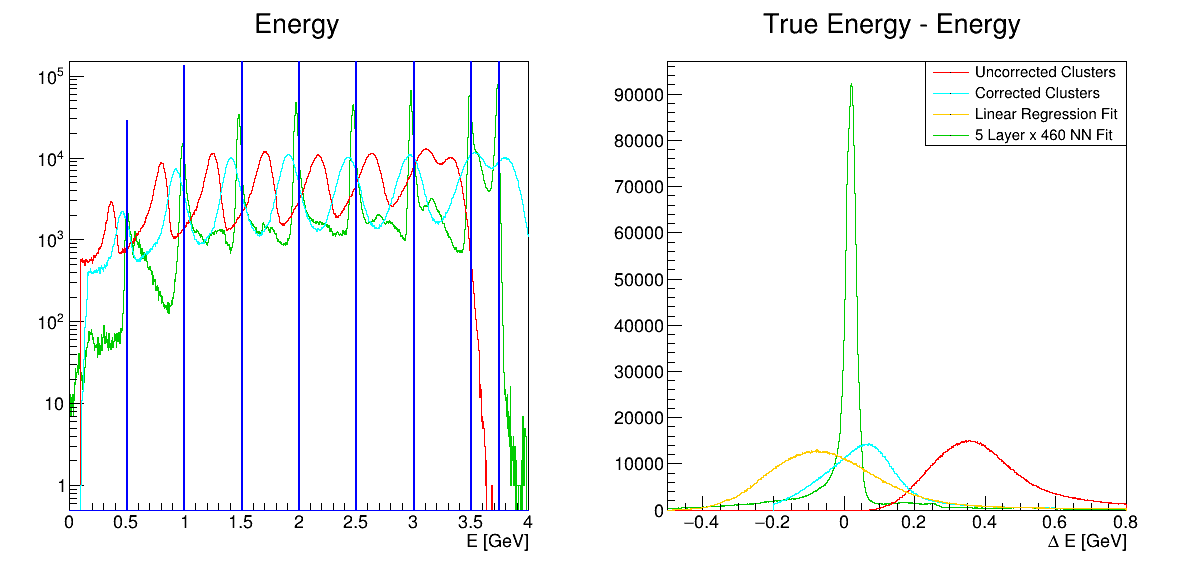

In [28]:
rfile = R.TFile("electrons_n1_M4_val.root")
t = rfile.Get("EcalTraining")
rdf_NN3 = R.RDataFrame(t)
rdf_NN3.GetColumnNames()
h6_true = rdf_NN3.Histo1D(("h_true", "True Energy;E [GeV]", 1000, 0., 4.), "true_e")
h6_clus = rdf_NN3.Histo1D(("h_clus", "Cluster Energy;E [GeV]", 1000, 0., 4.), "energy")
h6_clus_cor = rdf_NN3.Histo1D(("h_clus_cor", "Cluster Energy Cor;E [GeV]", 1000, 0., 4.), "energy_cor")
h6_fit = rdf_NN3.Histo1D(("h_fit", "Fit Energy;E [GeV]", 1000, 0., 4.), "energy_NN")
h6_df_clus = rdf_NN3.Define("d", "true_e - energy").Histo1D(
    ("h_df_clus", "Diff True - Cluster E;#Delta E [GeV]", 1000, -0.5, 0.8), "d")
h6_df_clus_cor = rdf_NN3.Define("d", "true_e - energy_cor").Histo1D(
    ("h_df_clus_cor", "Diff True - Corrected Cluster E;#Delta E [GeV]", 1000, -0.2, 0.8), "d")
h6_df_fit = rdf_NN3.Define("d", "true_e - energy_NN").Histo1D(
    ("h_df_fit", "Diff True - Fit E;#Delta E [GeV]", 1000, -0.5, 0.8), "d")
cc6 = R.TCanvas("cc6", "cc6", 1200, 600)
cc6.Divide(2, 1)
p1 = cc6.cd(1)
p1.SetLogy()
h6_clus.SetLineColor(R.kRed)
h6_clus_cor.SetLineColor(R.kCyan)
h6_fit.SetLineColor(R.kGreen+1)
h6_fit.SetStats(0)
h6_fit.SetTitle("Energy")
h6_fit.Draw()
h6_clus.Draw("same")
h6_clus_cor.Draw("same")
h6_true.SetLineColor(R.kBlue)
h6_true.Draw("same")
p2 = cc6.cd(2)
h6_df_clus.SetLineColor(R.kRed)
h6_df_clus_cor.SetLineColor(R.kCyan)
h6_df_fit.SetLineColor(R.kGreen+1)
h6_df_fit.SetStats(0)
h6_df_fit.SetTitle("True Energy - Energy")
h6_df_fit.Draw()
h6_df_clus.Draw("same")
h6_df_clus_cor.Draw("same")
h2_df_fit.SetLineColor(R.kOrange)
h2_df_fit.Draw("same")
leg6_p2 = R.TLegend(0.55, 0.75, 0.9, 0.9)
leg6_p2.AddEntry(h6_df_clus.GetPtr(), "Uncorrected Clusters")
leg6_p2.AddEntry(h6_df_clus_cor.GetPtr(), "Corrected Clusters")
leg6_p2.AddEntry(h2_df_fit.GetPtr(),"Linear Regression Fit")
leg6_p2.AddEntry(h6_df_fit.GetPtr(), "5 Layer x 460 NN Fit")
leg6_p2.Draw()
cc6.Draw()
cc6.SaveAs("Electron_score_e_NN4_L2_1em30_no_fidcut.pdf")